# Example: Fitting a General Linear Model (GLM) 

In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path

from nilearn.glm.first_level import make_first_level_design_matrix, run_glm

xr.set_options(display_expand_data=False)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "../../data/BIDS-NIRS-Tapping"

In [3]:
subjects  = [f"sub-{i:02d}" for i in [1,2,3,4,5]]

# store data of different subjects in a dictionary
data = {} 
for subject in subjects:
    
    elements = cedalion.io.read_snirf(
        os.path.join(DATADIR, f"{subject}/nirs/{subject}_task-tapping_nirs.snirf")
    )

    amp = elements[0].data[0]

    amp = amp.pint.dequantify().pint.quantify("volts") # work around missing units in snirf file

    stim = elements[0].stim # pandas Dataframe
    geo3d = elements[0].geo3d
    
    # cedalion registers an accessor (attribute .cd ) on pandas DataFrames
    stim.cd.rename_events( {
        "1.0" : "control",
        "2.0" : "Tapping/Left",
        "3.0" : "Tapping/Right"
    })
    
    dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : amp.wavelength})
    
    od = - np.log( amp / amp.mean("time") )
    conc = cedalion.nirs.beer_lambert(amp, geo3d, dpf)
    conc_ffiltered = conc.cd.freq_filter(0.05, 0.7, 4)

    data[subject] = xr.Dataset(
        data_vars = {
            "amp" : amp,
            "geo" : geo3d,
            "od"  : od,
            "conc": conc,
            "conc_ffiltered" : conc_ffiltered
        },
        attrs={"stim" : stim}, # store stimulus data in attrs
        coords={"subject" : subject} # add the subject label as a coordinate
    )

In [4]:
data["sub-01"]

<xarray.Dataset>
Dimensions:         (time: 23239, wavelength: 2, channel: 28, label: 55,
                     pos: 3, chromo: 2)
Coordinates:
  * time            (time) float64 0.0 0.128 0.256 ... 2.974e+03 2.974e+03
    samples         (time) int64 0 1 2 3 4 5 ... 23234 23235 23236 23237 23238
  * wavelength      (wavelength) float64 760.0 850.0
  * channel         (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
    source          (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector        (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D7' 'D8' 'D16'
  * label           (label) <U6 'S1' 'S2' 'S3' 'S4' 'S5' ... '25' '26' '27' '28'
    type            (label) object PointType.SOURCE ... PointType.LANDMARK
  * chromo          (chromo) <U3 'HbO' 'HbR'
    subject         <U6 'sub-01'
Dimensions without coordinates: pos
Data variables:
    amp             (channel, wavelength, time) float64 [V] 0.09137 ... 1.276
    geo             (label, pos) float64 [m] -0.04161 0.0268 ... 0.01751 0.06619
    od              (channel, wavelength, time) float64 [] 0.04042 ... -0.01317
    conc            (chromo, channel, time) float64 [µM] 0.1336 ... -1.076
    conc_ffiltered  (chromo, channel, time) float64 [µM] -0.001767 ... 0.004813
Attributes:
    stim:            onset  duration  value     trial_type\n0     61.824     ...

In [5]:
data["sub-01"].attrs["stim"]

onset  duration  value     trial_type
0     61.824       5.0    1.0        control
1     87.296       5.0    1.0        control
2    181.504       5.0    1.0        control
3    275.712       5.0    1.0        control
4    544.640       5.0    1.0        control
..       ...       ...    ...            ...
87  2234.112       5.0    1.0  Tapping/Right
88  2334.848       5.0    1.0  Tapping/Right
89  2362.240       5.0    1.0  Tapping/Right
90  2677.504       5.0    1.0  Tapping/Right
91  2908.032       5.0    1.0  Tapping/Right

[92 rows x 4 columns]

In [6]:
amp = data["sub-01"].amp
geo3d = data["sub-01"].geo

dists = xrutils.norm(geo3d.loc[amp.source] - geo3d.loc[amp.detector], dim="pos").pint.to("mm").round(2)
short_channels = dists.channel[dists < 1 * cedalion.units.cm]
display(short_channels)
display(dists.loc[short_channels])

<xarray.DataArray 'channel' (channel: 8)>
'S1D9' 'S2D10' 'S3D11' 'S4D12' 'S5D13' 'S6D14' 'S7D15' 'S8D16'
Coordinates:
    subject   <U6 'sub-01'
  * channel   (channel) object 'S1D9' 'S2D10' 'S3D11' ... 'S7D15' 'S8D16'
    source    (channel) object 'S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
    detector  (channel) object 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'D16'

<xarray.DataArray 'geo' (channel: 8)>
[mm] 8.26 7.12 7.78 8.24 7.7 8.07 7.32 7.53
Coordinates:
    subject   <U6 'sub-01'
  * channel   (channel) object 'S1D9' 'S2D10' 'S3D11' ... 'S7D15' 'S8D16'
    source    (channel) object 'S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8'
    detector  (channel) object 'D9' 'D10' 'D11' 'D12' 'D13' 'D14' 'D15' 'D16'

In [7]:
stim = data["sub-01"].attrs["stim"]
stim = stim[stim.trial_type != "15.0"] # remove trial 15.0
stim_copy = stim.copy()
stim_copy["duration"] = 1.0




X = make_first_level_design_matrix(
    data["sub-01"].conc.time.values,
    stim_copy, # column names of the stimulus dataframe matches nilearn's expectations,
    drift_model="polynomial",
    drift_order=3,
    hrf_model='fir',
    fir_delays=np.arange(20) * np.floor(amp.cd.sampling_rate)
)

display(X)

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `value` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "


Tapping/Left_delay_0  Tapping/Left_delay_7  Tapping/Left_delay_14   
0.000                      0.0                   0.0                    0.0  \
0.128                      0.0                   0.0                    0.0   
0.256                      0.0                   0.0                    0.0   
0.384                      0.0                   0.0                    0.0   
0.512                      0.0                   0.0                    0.0   
...                        ...                   ...                    ...   
2973.952                   0.0                   0.0                    0.0   
2974.080                   0.0                   0.0                    0.0   
2974.208                   0.0                   0.0                    0.0   
2974.336                   0.0                   0.0                    0.0   
2974.464                   0.0                   0.0                    0.0   

          Tapping/Left_delay_21  Tapping/Left_delay_28  Tapping/Left_delay_35   
0.000                       0.0                    0.0                    0.0  \
0.128                       0.0                    0.0                    0.0   
0.256                       0.0                    0.0                    0.0   
0.384                       0.0                    0.0                    0.0   
0.512                       0.0                    0.0                    0.0   
...                         ...                    ...                    ...   
2973.952                    0.0                    0.0                    0.0   
2974.080                    0.0                    0.0                    0.0   
2974.208                    0.0                    0.0                    0.0   
2974.336                    0.0                    0.0                    0.0   
2974.464                    0.0                    0.0                    0.0   

          Tapping/Left_delay_42  Tapping/Left_delay_49  Tapping/Left_delay_56   
0.000                       0.0                    0.0                    0.0  \
0.128                       0.0                    0.0                    0.0   
0.256                       0.0                    0.0                    0.0   
0.384                       0.0                    0.0                    0.0   
0.512                       0.0                    0.0                    0.0   
...                         ...                    ...                    ...   
2973.952                    0.0                    0.0                    0.0   
2974.080                    0.0                    0.0                    0.0   
2974.208                    0.0                    0.0                    0.0   
2974.336                    0.0                    0.0                    0.0   
2974.464                    0.0                    0.0                    0.0   

          Tapping/Left_delay_63  ...  control_delay_98  control_delay_105   
0.000                       0.0  ...               0.0                0.0  \
0.128                       0.0  ...               0.0                0.0   
0.256                       0.0  ...               0.0                0.0   
0.384                       0.0  ...               0.0                0.0   
0.512                       0.0  ...               0.0                0.0   
...                         ...  ...               ...                ...   
2973.952                    0.0  ...               0.0                0.0   
2974.080                    0.0  ...               0.0                0.0   
2974.208                    0.0  ...               0.0                0.0   
2974.336                    0.0  ...               0.0                0.0   
2974.464                    0.0  ...               0.0                0.0   

          control_delay_112  control_delay_119  control_delay_126   
0.000                   0.0                0.0                0.0  \
0.128                   0.0                0.0      

In [8]:
# add short channel regressor
conc_ffiltered = data["sub-01"].conc_ffiltered
X["short_channels"] = conc_ffiltered.sel(channel=short_channels, chromo="HbO").mean("channel")

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [9]:
X = xr.DataArray(
    X.values,
    dims = ["time", "regressor"],
    coords = {
        "time" : data["sub-01"].conc.time,
        "regressor" : X.columns
    }
)
display(X)

<xarray.DataArray (time: 23239, regressor: 65)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.5 0.1667 0.04999 1.0 0.01567
Coordinates:
  * time       (time) float64 0.0 0.128 0.256 ... 2.974e+03 2.974e+03 2.974e+03
  * regressor  (regressor) object 'Tapping/Left_delay_0' ... 'short_channels'

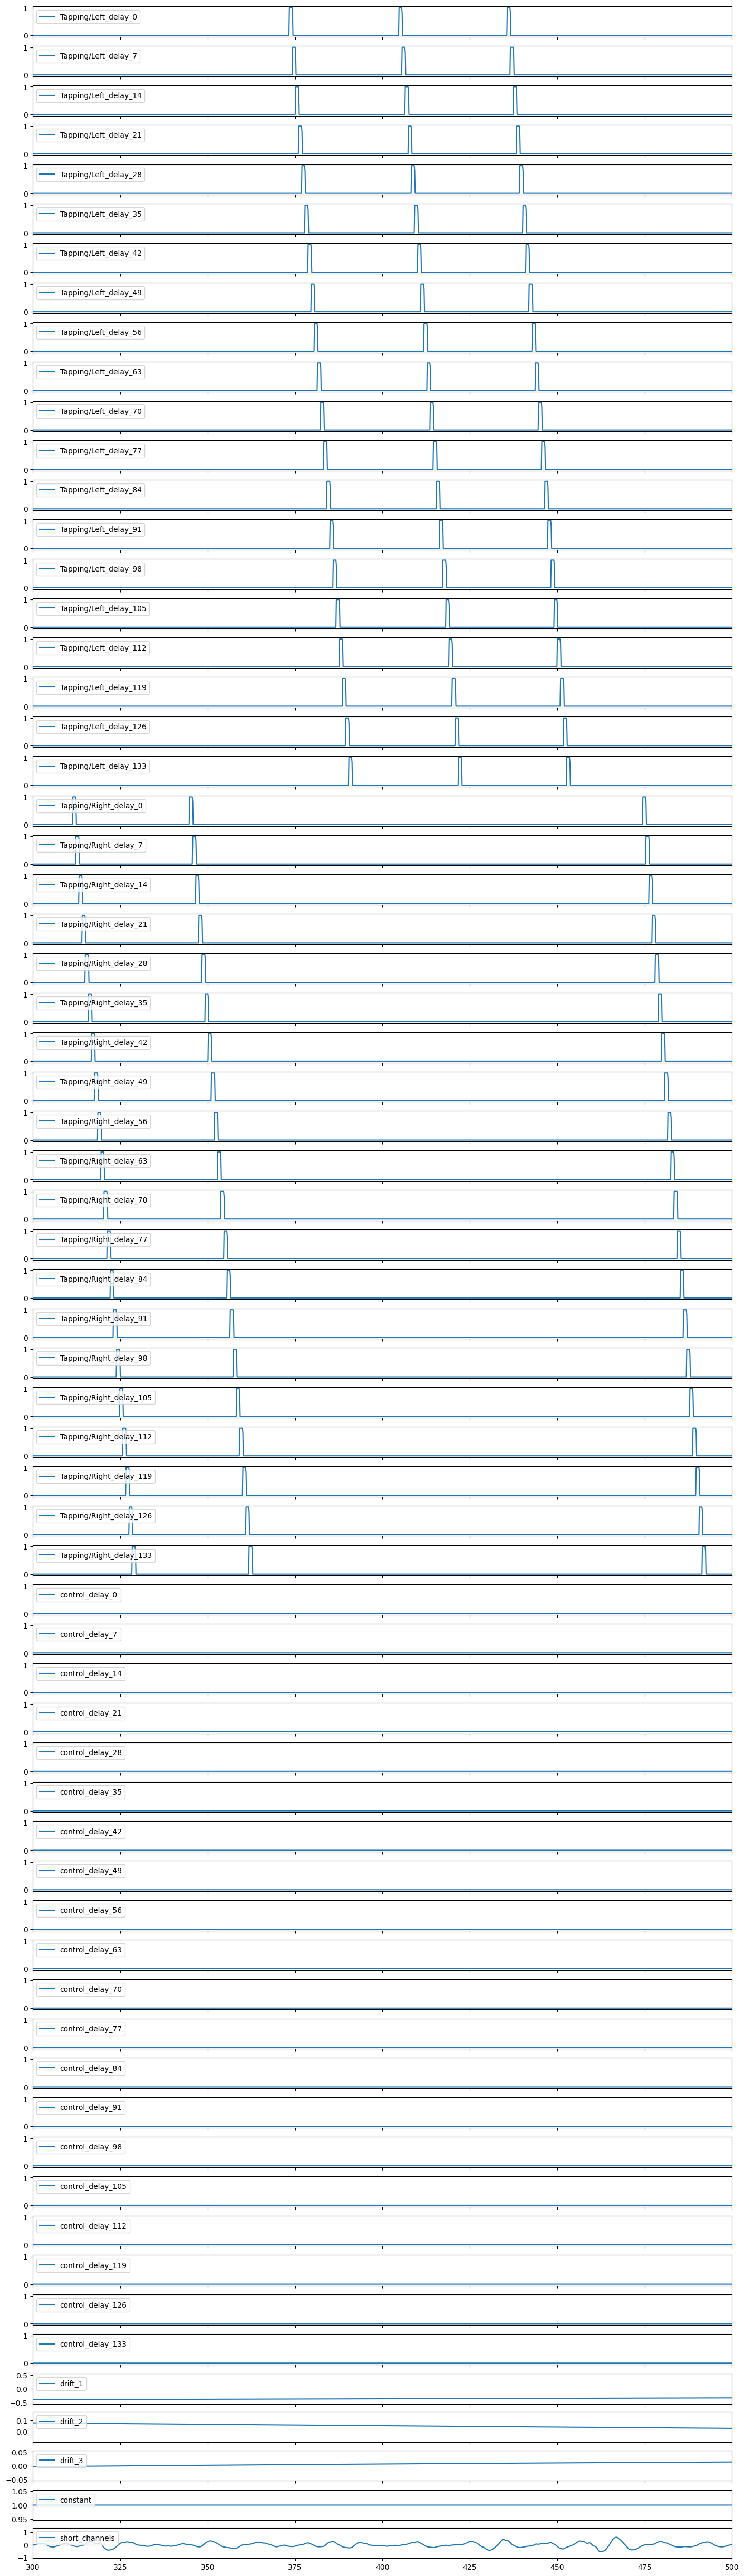

In [10]:
nregressors = X.sizes["regressor"]
f,ax = p.subplots(nregressors, 1, sharex=True, figsize=(14,0.75*nregressors), layout="constrained")
for i, reg in enumerate(X.regressor.values):
    ax[i].plot(X.time, X.loc[:,reg], label=reg)
    ax[i].legend(loc="upper left")

    ax[i].set_xlim(300,500)

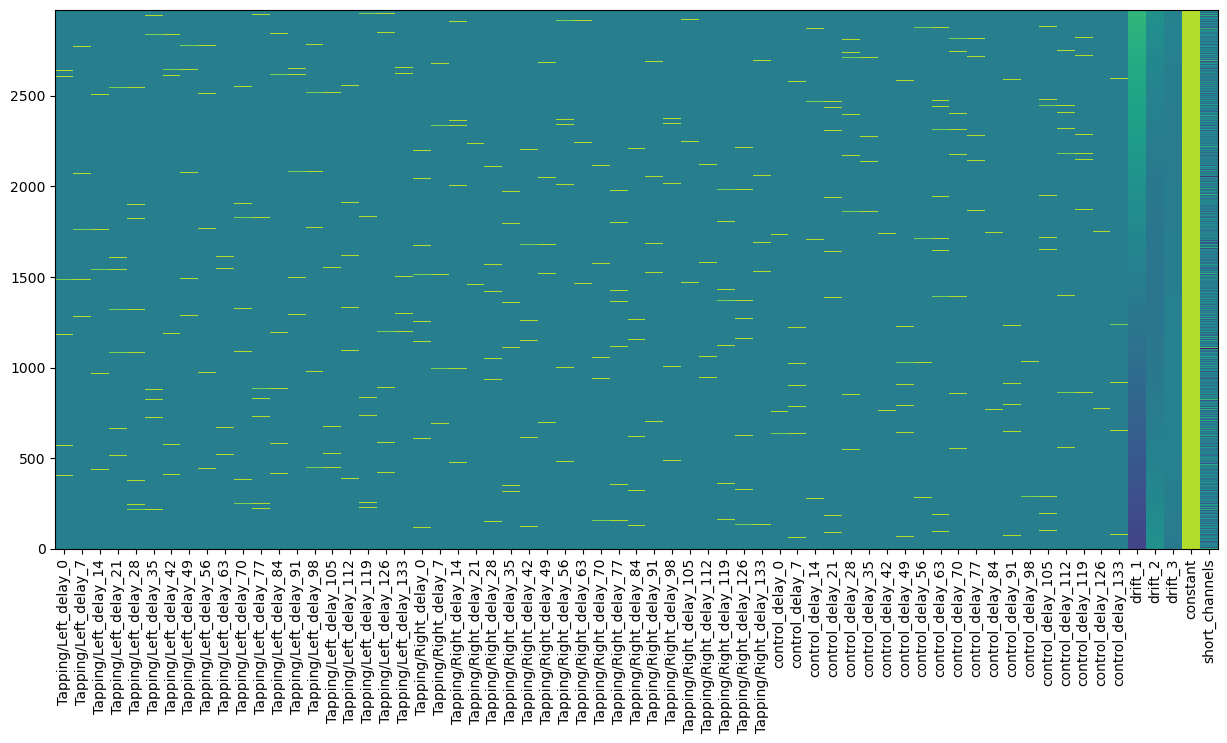

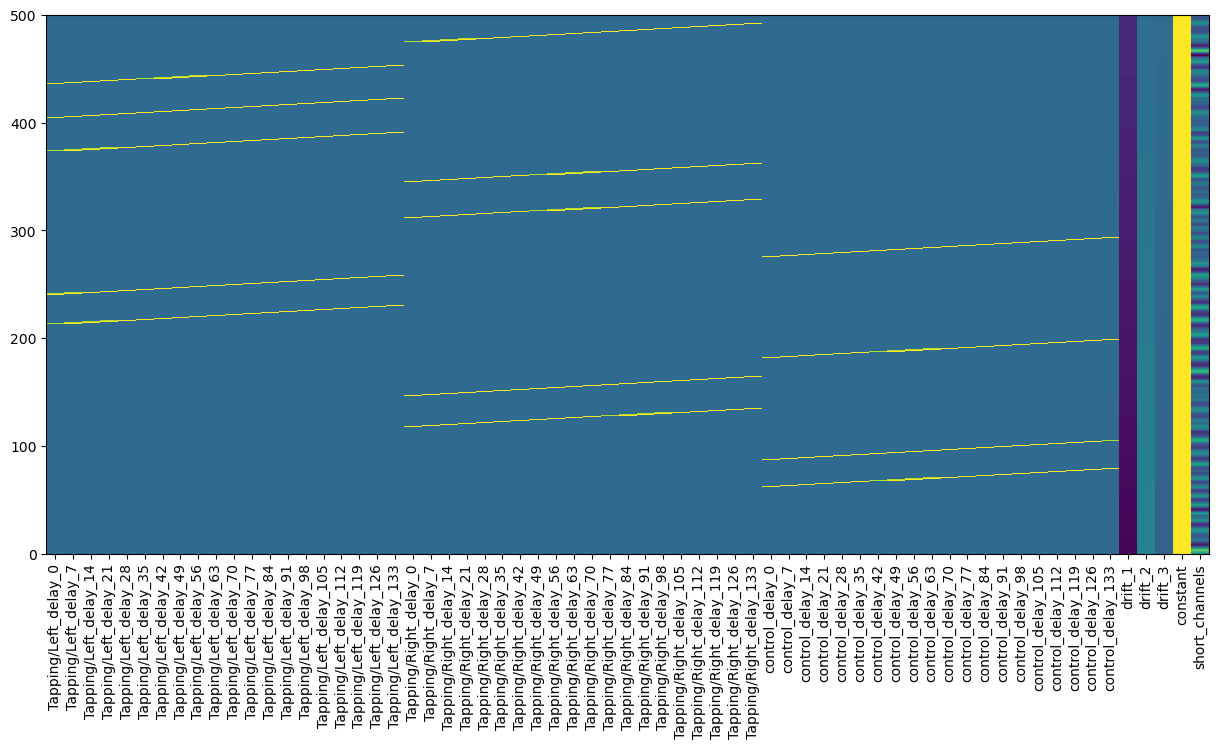

In [11]:
f,ax = p.subplots(1,1, figsize=(15,7))
ax.pcolormesh(X.regressor, X.time, X, shading="nearest")
p.xticks(rotation=90);

# plot only first 500 seconds
XX = X[X.time < 500]
f,ax = p.subplots(1,1, figsize=(15,7))
ax.pcolormesh(XX.regressor, XX.time, XX, shading="nearest")
p.xticks(rotation=90);

In [12]:
conc_ffiltered = data["sub-01"].conc_ffiltered
b = conc_ffiltered.sel(chromo="HbO").transpose("time", "channel")

#betas, residuals, rank, s = np.linalg.lstsq(X, b)
#betas = xr.DataArray(
#    betas,
#    dims = ["regressor", "channel"],
#    coords = [X.regressor, conc.channel]
#)
#display(betas)

labels, result = run_glm(b.values, X.values, noise_model="ols", verbose=True)


/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [13]:
thetas = result[labels[0]].theta # shape (nregressors, nchannel) and equal for all results
thetas = xr.DataArray(
    thetas,
    dims = ("regressor", "channel"),
    coords = {
        "regressor" : X.regressor,
        "channel" : b.channel
    }
)
display(thetas)

<xarray.DataArray (regressor: 65, channel: 28)>
-0.03526 -0.0197 -0.01678 0.01396 -0.01181 ... 0.7734 1.187 0.5957 0.4924 0.878
Coordinates:
  * regressor  (regressor) object 'Tapping/Left_delay_0' ... 'short_channels'
  * channel    (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'

<xarray.DataArray (time: 23239, channel: 28)>
0.03582 0.02631 0.02853 0.03941 0.02404 ... 0.0187 0.01153 0.01156 0.01421
Coordinates:
  * time     (time) float64 0.0 0.128 0.256 ... 2.974e+03 2.974e+03 2.974e+03
  * channel  (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'

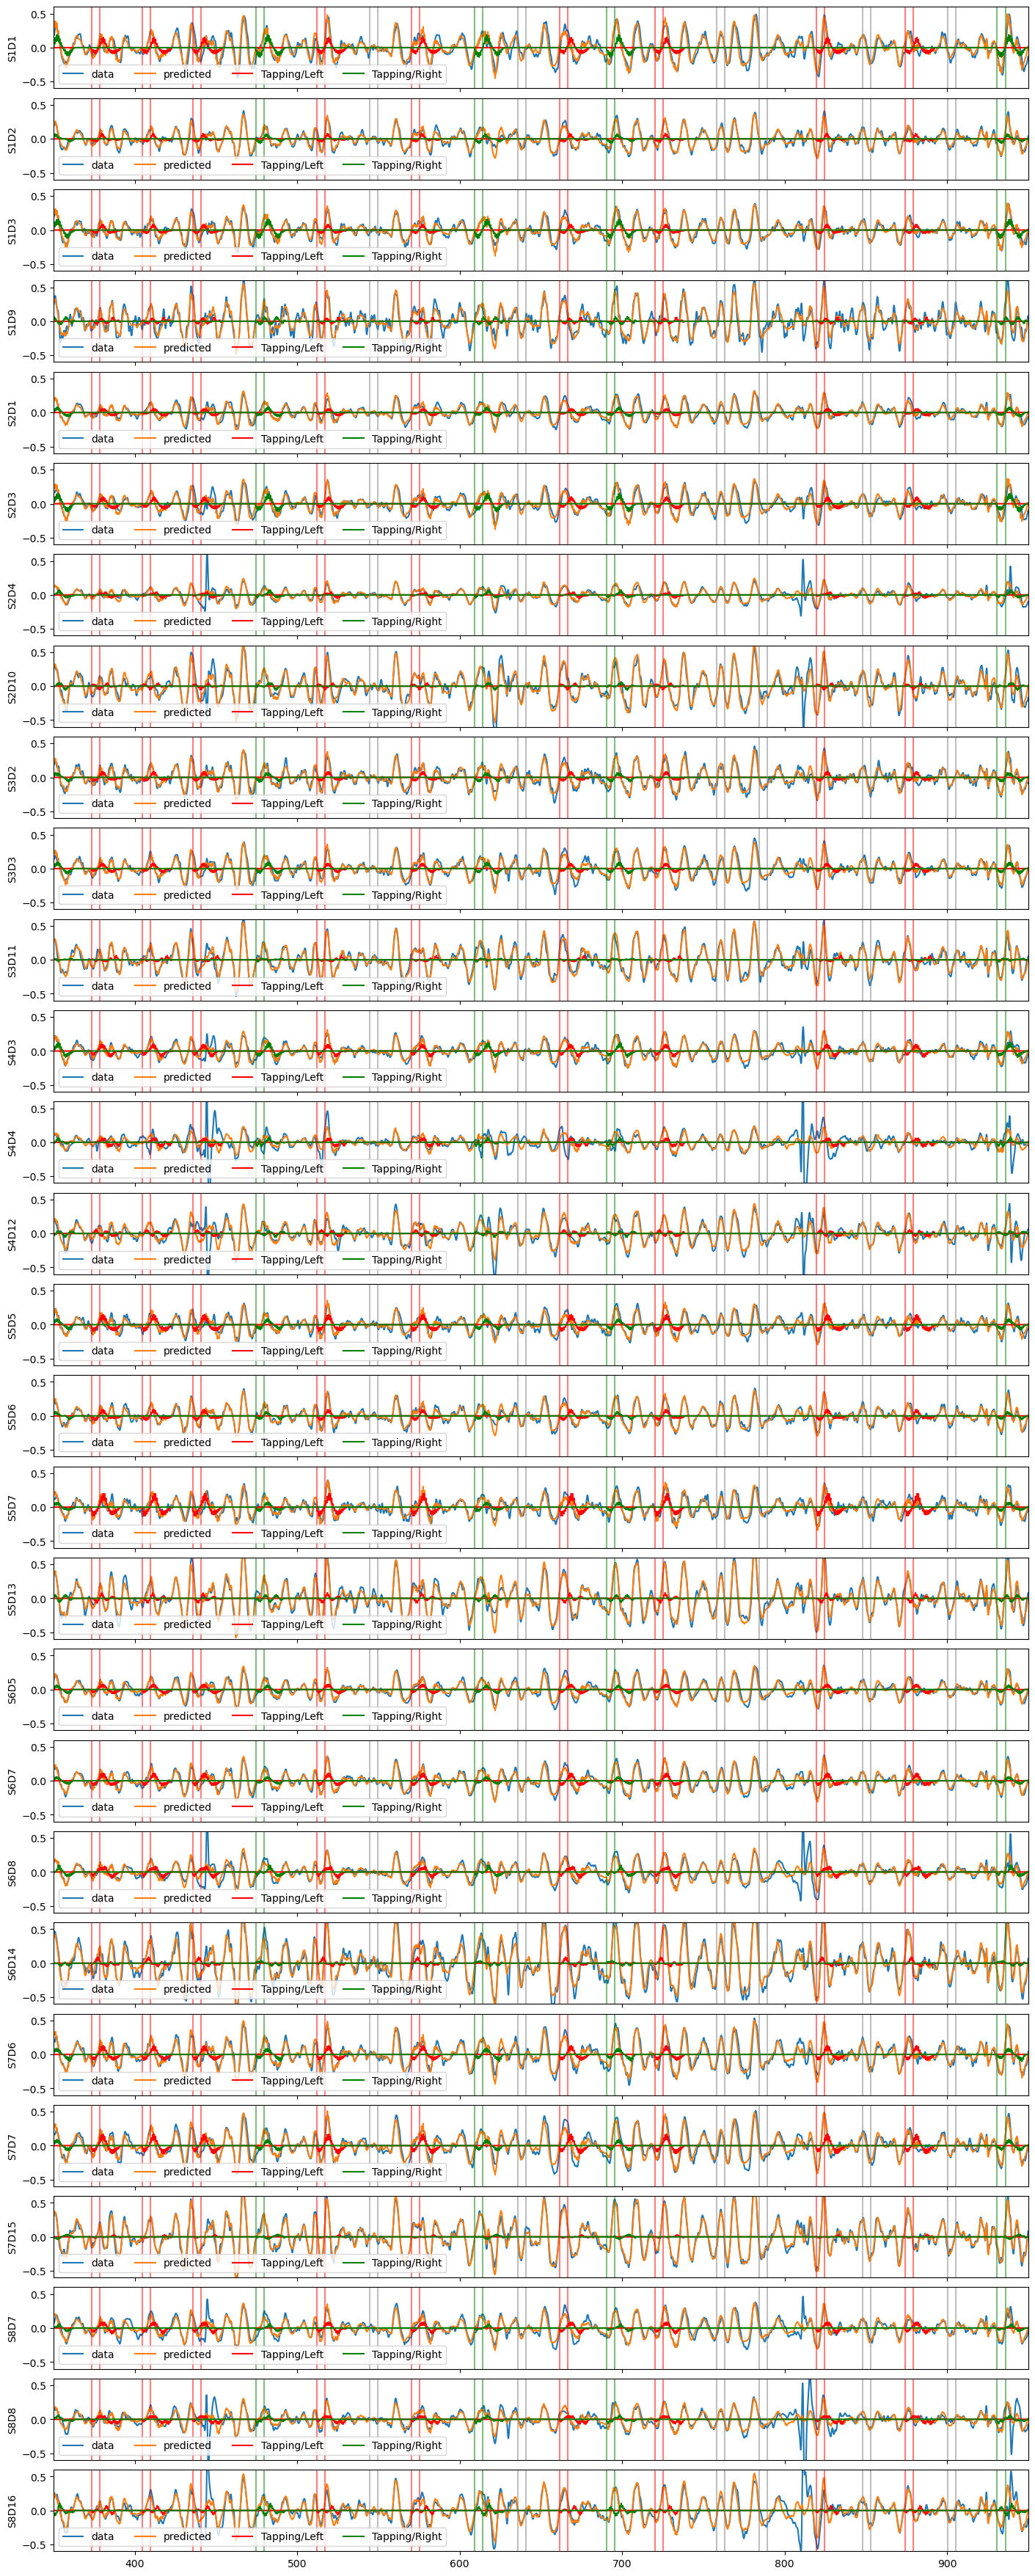

In [14]:
predicted = X @ thetas
predicted_left = X @ thetas[thetas.regressor.str.startswith("Tapping/Left")]
predicted_right = X @ thetas[thetas.regressor.str.startswith("Tapping/Right")]
display(predicted)

colors = p.rcParams["axes.prop_cycle"].by_key()["color"]

colors = {
    "Tapping/Left" : "r",
    "Tapping/Right" : "g",
    "control" : "gray"
}

f, ax = p.subplots(predicted.sizes["channel"],1,figsize=(14,1.25*predicted.sizes["channel"]), sharex=True, layout="constrained")
for i, ch in enumerate(predicted.channel.values):
    ax[i].plot(b.time, b.sel(channel=ch), label="data")
    ax[i].plot(predicted.time, predicted.sel(channel=ch), label="predicted")

    ax[i].plot(predicted_left.time, predicted_left.sel(channel=ch), c="r", label="Tapping/Left")
    ax[i].plot(predicted_right.time, predicted_right.sel(channel=ch), c="g", label="Tapping/Right")

    ax[i].set_ylabel(ch)
    ax[i].set_xlim(350,950)
    ax[i].set_ylim(-0.6,0.6)
    ax[i].legend(loc="lower left", ncol=4)

    for i_c, (trial_type, df) in enumerate(stim.groupby("trial_type")):
        color = colors[trial_type]
        for idx, row in df.iterrows():
            ax[i].axvline(row["onset"], c=color, alpha=.5)
            ax[i].axvline(row["onset"]+row["duration"], c=color, alpha=.5)

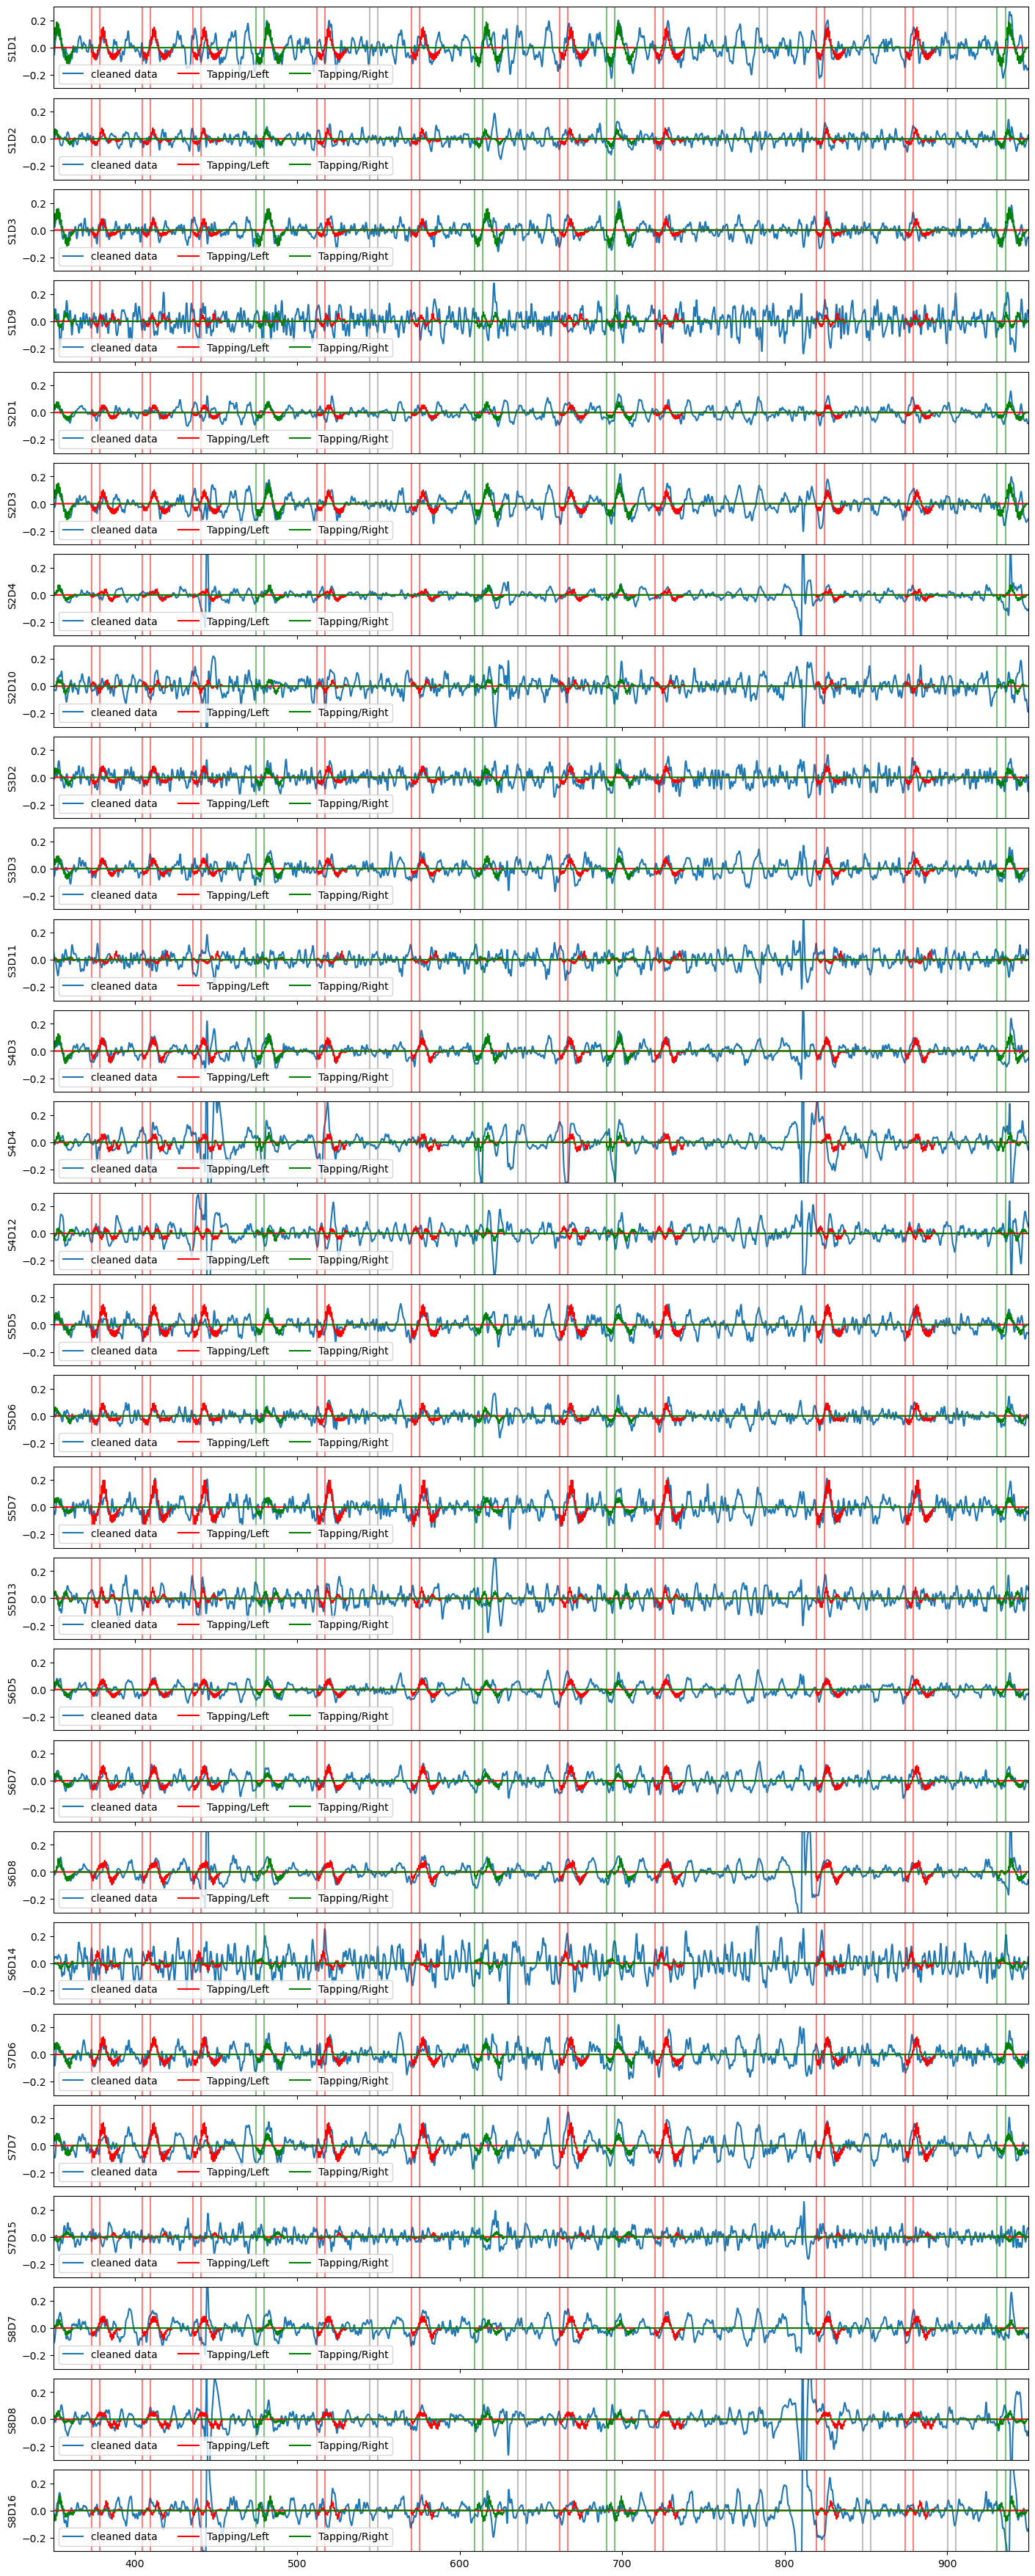

In [15]:
predicted_bg = X @ thetas[thetas.regressor.isin(["drift_1", "drift_2", "drift_3", "constant", "short_channels"])]
cleaned_b = b.pint.dequantify() - predicted_bg

f, ax = p.subplots(predicted.sizes["channel"],1,figsize=(14,1.25*predicted.sizes["channel"]), sharex=True, layout="constrained")
for i, ch in enumerate(predicted.channel.values):
    ax[i].plot(cleaned_b.time, cleaned_b.sel(channel=ch), label="cleaned data")

    ax[i].plot(predicted_left.time, predicted_left.sel(channel=ch), c="r", label="Tapping/Left")
    ax[i].plot(predicted_right.time, predicted_right.sel(channel=ch), c="g", label="Tapping/Right")

    ax[i].set_ylabel(ch)
    ax[i].set_xlim(350,950)
    ax[i].set_ylim(-0.3,0.3)
    ax[i].legend(loc="lower left", ncol=4)

    for i_c, (trial_type, df) in enumerate(stim.groupby("trial_type")):
        color = colors[trial_type]
        for idx, row in df.iterrows():
            ax[i].axvline(row["onset"], c=color, alpha=.5)
            ax[i].axvline(row["onset"]+row["duration"], c=color, alpha=.5)


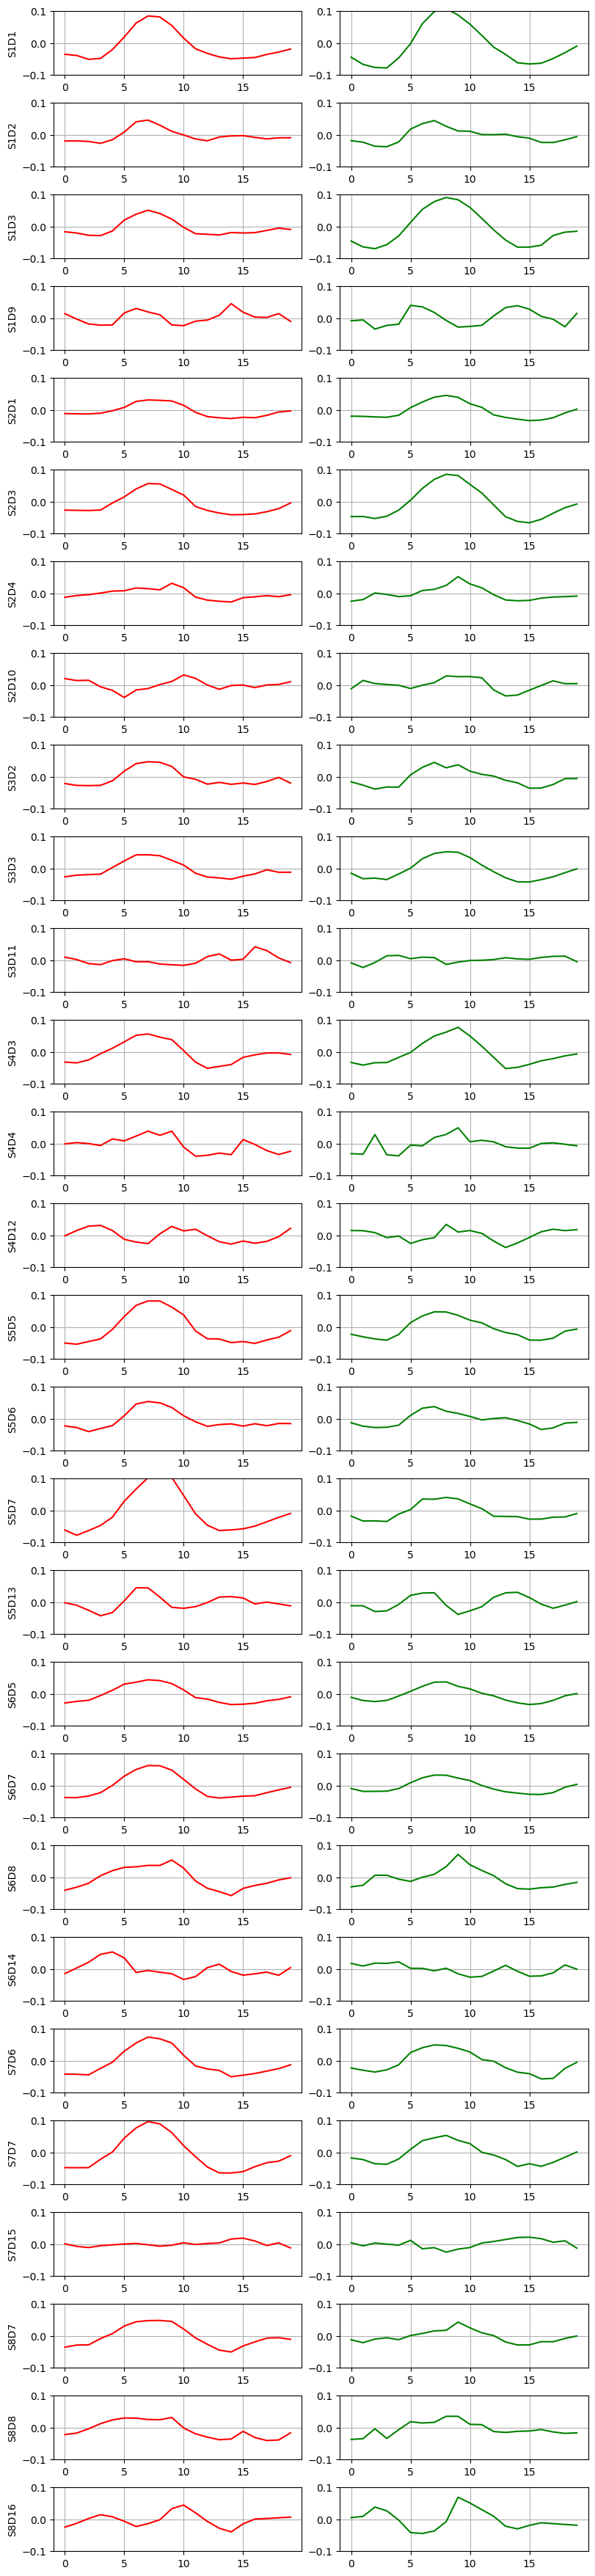

In [17]:
f, ax = p.subplots(thetas.sizes["channel"], 2, figsize=(8, 1.25 * thetas.sizes["channel"]), layout="constrained")

for i, ch in enumerate(thetas.channel.values):
    ax[i, 0].plot(thetas.sel(channel=ch, regressor=thetas.regressor.str.startswith("Tapping/Left")), c="r")
    ax[i, 1].plot(thetas.sel(channel=ch, regressor=thetas.regressor.str.startswith("Tapping/Right")), c="g")
    for j in [0,1]:
        ax[i, j].set_ylim(-.1,.1)
        ax[i, j].grid(1)
    ax[i, 0].set_ylabel(ch)
